# Домашнее задание
## Почувствуй мощь трансформеров в бою
В качестве данных выберете возьмите датасет RuCola для русского языка https://github.com/RussianNLP/RuCoLA (в качестве train возьмите in_domain_train.csv, а в качестве теста in_domain_dev.csv)
Разбейте in_domain_train на train и val
Зафайнтьюньте и протестируйте RuBert или RuRoBerta на данной задаче (можно взять любую предобученную модель руберт с сайта huggingface. Например, ruBert-base/large https://huggingface.co/sberbank-ai/ruBert-base / https://huggingface.co/sberbank-ai/ruBert-large или rubert-base-cased https://huggingface.co/DeepPavlov/rubert-base-cased, ruRoberta-large https://huggingface.co/sberbank-ai/ruRoberta-large, xlm-roberta-base https://huggingface.co/xlm-roberta-base)
Возьмите RuGPT3 base или large и решите данное задание с помощью методов few-/zero-shot
а) переберите несколько вариантов затравок
б) протестируйте различное число few-shot примеров (0, 1, 2, 4)
Обучите и протестируйте модель RuT5 на данной задаче (пример finetun’а можете найти здесь https://github.com/RussianNLP/RuCoLA/blob/main/baselines/finetune_t5.py)
Сравните полученные результаты


Критерии оценки:
Файнтьюн БЕРТА - 3 балла
Реализация few-/zero-shot c GPT3 - 4 балла
Файнтьюн RuT5 - 3 балла

## BERT Fine-Tuning

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=865ee4bb3b37d56b7a1d732134ad3970b38a240682de3ff7ba2c9aecd4ae2ed2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
!git clone https://github.com/RussianNLP/RuCoLA.git

Cloning into 'RuCoLA'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 73 (delta 30), reused 52 (delta 22), pack-reused 0
Receiving objects: 100% (73/73), 944.21 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
import pandas as pd

train_path = "RuCoLA/data/in_domain_train.csv"
train_df = pd.read_csv(train_path, index_col="id")

print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

train_df.head()

Number of training sentences: 7,869



,sentence,acceptable,error_type,detailed_source
id,,,,
0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010


In [5]:
import transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [6]:
sentences = train_df.sentence
labels = train_df.acceptable

max_sent_len = 0

for sent in sentences:
  curr_sent_len = len(tokenizer.encode(sent, add_special_tokens=True))
  if curr_sent_len > max_sent_len:
    max_sent_len = curr_sent_len

new_sent_len = 1 << (max_sent_len - 1).bit_length() if (max_sent_len & (max_sent_len - 1)) != 0 else max_sent_len

print(f"Округляю {max_sent_len} до {new_sent_len}")

input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
      sent,
      add_special_tokens = True,
      max_length = 64,
      padding = "max_length",
      return_attention_mask = True,
      return_tensors = 'pt',
  )

  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Округляю 46 до 64


In [7]:
import numpy as np

def flat_acc(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  return np.sum(preds_flat == labels_flat) / len(labels_flat)

In [8]:
from torch.utils.data import TensorDataset, random_split

my_dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(my_dataset))
val_size = len(my_dataset) - train_size

train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size])

In [9]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [10]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
    )
model.to(device);

optimizer = AdamW(
    model.parameters(),
    lr=2e-5
)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Обучение

In [11]:
import random

from tqdm import tqdm

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_loss_list = []
valid_loss_list = []

train_acc_list = []
valid_acc_list = []

epochs = 3

for epoch in range(epochs):
  total_train_loss = 0
  total_train_acc = 0

  model.train()
  pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

  for step, sample in pbar:
    model.zero_grad()

    input_ids, attention_masks, labels = sample

    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    labels = labels.to(device)

    res = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_masks,
        labels=labels
    )

    loss = res['loss']
    logits = res['logits']

    curr_loss = loss.item()
    total_train_loss += curr_loss

    curr_acc = flat_acc(logits.cpu().detach().numpy(), labels.cpu().numpy())
    total_train_acc += curr_acc

    pbar.set_description(f"Train Loss: {curr_loss:.4f}; Train Accuracy: {curr_acc:.4f}")

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  avg_train_acc = total_train_acc / len(train_dataloader)

  train_loss_list.append(avg_train_loss)
  train_acc_list.append(avg_train_acc)

  print(f"Avg Train Loss: {avg_train_loss:.4f}\nAvg Train Acc: {avg_train_acc:.4f}\n")

  pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))

  total_valid_loss = 0
  total_valid_acc = 0

  model.eval()

  with torch.no_grad():

    for step, sample in pbar:
      input_ids, attention_masks, labels = sample

      input_ids = input_ids.to(device)
      attention_masks = attention_masks.to(device)
      labels = labels.to(device)

      res = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_masks,
        labels=labels
      )

      loss = res['loss']
      logits = res['logits']

      curr_loss = loss.item()
      total_valid_loss += curr_loss

      curr_acc = flat_acc(logits.cpu().detach().numpy(), labels.cpu().numpy())
      total_valid_acc += curr_acc

      pbar.set_description(f"Valid Loss: {curr_loss:.4f}; Valid Accuracy: {curr_acc:.4f}")

  avg_valid_loss = total_valid_loss / len(val_dataloader)
  avg_valid_acc = total_valid_acc / len(val_dataloader)

  valid_loss_list.append(avg_valid_loss)
  valid_acc_list.append(avg_valid_acc)

  print(f"Avg Valid Loss: {avg_valid_loss:.4f}\nAvg Valid Acc: {avg_valid_acc:.4f}\n")

Train Loss: 0.7064; Train Accuracy: 0.7000: 100%|██████████| 222/222 [01:14<00:00,  2.97it/s]


Avg Train Loss: 0.5590
Avg Train Acc: 0.7481



Valid Loss: 0.7221; Valid Accuracy: 0.6842: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Avg Valid Loss: 0.5218
Avg Valid Acc: 0.7561



Train Loss: 0.1057; Train Accuracy: 1.0000: 100%|██████████| 222/222 [01:15<00:00,  2.93it/s]


Avg Train Loss: 0.4565
Avg Train Acc: 0.7973



Valid Loss: 0.6231; Valid Accuracy: 0.7368: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Avg Valid Loss: 0.5133
Avg Valid Acc: 0.7795



Train Loss: 0.2189; Train Accuracy: 1.0000: 100%|██████████| 222/222 [01:17<00:00,  2.86it/s]


Avg Train Loss: 0.2974
Avg Train Acc: 0.8811



Valid Loss: 0.6382; Valid Accuracy: 0.6842: 100%|██████████| 25/25 [00:02<00:00,  8.75it/s]

Avg Valid Loss: 0.5355
Avg Valid Acc: 0.7699



### Train and Valid Loss and Accuracy

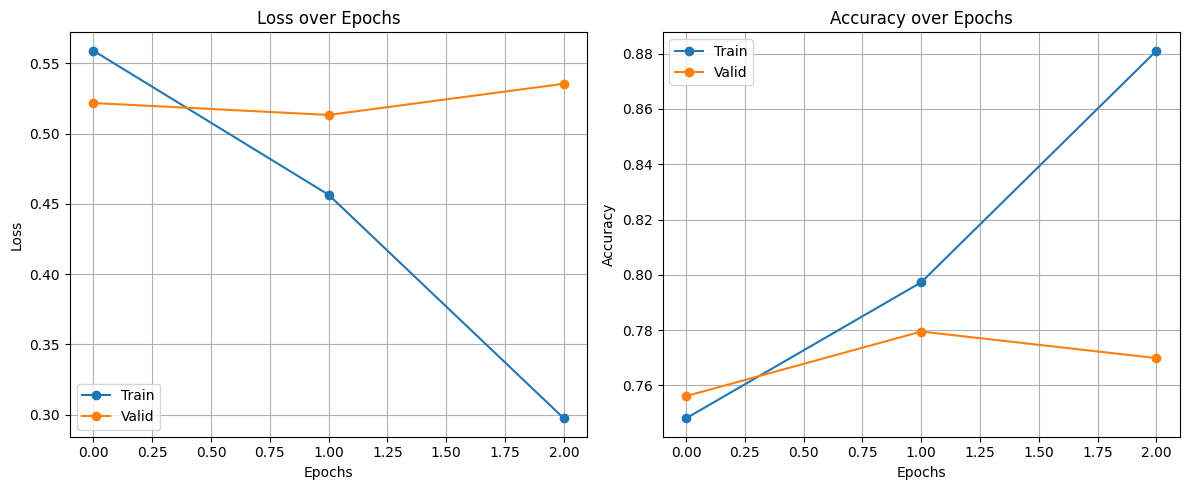

In [12]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(epochs, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Loss over Epochs")
    plt.plot(range(epochs), train_loss_list, marker="o", label="Train")
    plt.plot(range(epochs), valid_loss_list, marker="o", label="Valid")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.title("Accuracy over Epochs")
    plt.plot(range(epochs), train_acc_list, marker="o", label="Train")
    plt.plot(range(epochs), valid_acc_list, marker="o", label="Valid")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Пример использования
plot_loss_and_accuracy(epochs, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list)


### Evaluation on Test data

In [13]:
test_path = "RuCoLA/data/in_domain_dev.csv"
test_df = pd.read_csv(test_path, index_col="id")

test_df.head()

,sentence,acceptable,error_type,detailed_source
id,,,,
0,Иван вчера не позвонил.,1,0,Paducheva2013
1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8
2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5
3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova
4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets


In [14]:
test_sentences = test_df.sentence
test_labels = test_df.acceptable

input_ids = []
attention_masks = []

for sent in test_sentences:
  encode_dict = tokenizer.encode_plus(
      sent,
      add_special_tokens = True,
      max_length=new_sent_len,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt',
  )
  input_ids.append(encode_dict['input_ids'])
  attention_masks.append(encode_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [15]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [16]:
from sklearn.metrics import matthews_corrcoef

def calc_mcc_from_logits(true_labels, predictions):
  matthews_set = []

  # For each input batch...
  for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # Calculate the MCC
  mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

  print('Total MCC: %.3f' % mcc)

In [17]:
calc_mcc_from_logits(true_labels, predictions)

Total MCC: 0.374


## Few-shot zero-shot GPT3

попробовать другую структуру промпта

протестить small-medium-large модели, сравнить качество, память и время

протестить всё что указано в задании

после всего сделать сводку

In [91]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3medium_based_on_gpt2")

model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3medium_based_on_gpt2")
model.cuda();

In [85]:
test_df[test_df["acceptable"] == 0].sample(5)

,sentence,acceptable,error_type,detailed_source
id,,,,
284,Вопреки ожиданий служба в полку была полна нео...,0,Syntax,USE8
979,"Не должно быть подозрений, что судью привлекаю...",0,Semantics,Paducheva2013
275,Ты должен взять любую из этих книг.,0,Semantics,Seliverstova
42,"На конференцию, которая проходила в Москве, пр...",0,Syntax,USE8
266,"Я слышал вой и лай собак и радовался, вообража...",0,Semantics,Seliverstova


In [86]:
pd.unique(test_df.error_type)

array(['0', 'Syntax', 'Semantics', 'Morphology'], dtype=object)

In [87]:
def calc_loss(phrase: str,
                        tokenizer,
                        model):

    phrase = tokenizer.encode(phrase)
    # Если длина фразы 1 токен, то дальше ошибка вылезет :(
    if len(phrase) == 1:
         phrase.append(tokenizer.eos_token_id)
    phrase = torch.tensor(phrase, dtype=torch.long, device=device)
    phrase = phrase.unsqueeze(0)  # .repeat(num_samples, 1)
    with torch.no_grad():
        loss = model(phrase, labels=phrase)

    loss[0].item()


    return loss[0].item()

def get_loss_num(text):
    loss = calc_loss(phrase=text, model=model, tokenizer=tokenizer)
    return loss

In [88]:
text = "Мама мыла раму"
get_loss_num("Предложение далее корректное? " + "Мама мыла раму" + " Ответ: да.")

5.684020042419434

In [89]:
text = "Мама мыла раму"
get_loss_num("Предложение далее корректное? " + text + " Ответ: нет.")

5.733269214630127

In [90]:
test_tuple = (get_loss_num("Предложение далее корректное? " + "Илья быть дома пришёл" + " Ответ: да."),
              get_loss_num("Предложение далее корректное? " + "Илья быть дома пришёл" + " Ответ: нет."))
print(test_tuple)
np.argmin(test_tuple)

(7.504948139190674, 7.513453483581543)


0

### Zero-shot

In [93]:
%%time
import random

sentences = test_df.sentence
labels = test_df.acceptable

few_shots = [
    "Предложение далее корректное? " + "Собака лает на прохожих." + " Ответ: да.",
    "Предложение далее корректное? " + "Человек идет в и магазин." + " Ответ: нет.",
    "Предложение далее корректное? " + "Птицы поют на деревьях." + " Ответ: да.",
    "Предложение далее корректное? " + "Они гулять по парку." + " Ответ: нет.",
    "Предложение далее корректное? " + "Книга лежит на столе." + " Ответ: да.",
    "Предложение далее корректное? " + "Она любить читать книги." + " Ответ: нет."
]

model.eval()

predictions = []

for sent, label in zip(sentences, labels):
  false_sent_loss = get_loss_num("\n".join(few_shots) + "\nПредложение далее корректное? " + sent + " Ответ: нет.")
  true_sent_loss = get_loss_num("\n".join(few_shots) + "\nПредложение далее корректное? " + sent + " Ответ: да.")

  loss_tuple = (false_sent_loss, true_sent_loss)
  # predictions.append(random.choice([0, 1]))
  predictions.append(np.argmin(loss_tuple))

matthews_corrcoef(labels, predictions)

CPU times: user 58.9 s, sys: 142 ms, total: 59 s
Wall time: 59.7 s


0.024204609500913212